# Model Experimentation Tracking (MLFow)

### Record and query experiments: Code, data, config, results, parameters, metrics

![Data](images/MLflow_Model_experimentation.png)

## Import Packages

In [1]:
# Data analysis library
import numpy as np
import pandas as pd

# Machine Learning library
import sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric

# Model experimentation library
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Plotting library
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'mlflow version is {mlflow.__version__}')

Numpy version is 1.19.4
Pandas version is 1.1.5
sklearn version is 0.23.2
mlflow version is 1.12.1


## Download data 

### Campus Recruitment Dataset
#### Academic and Employability Factors influencing placement

https://www.kaggle.com/benroshan/factors-affecting-campus-placement

## Load data

In [3]:
## Files
data_file = '../data/placement_data/Placement_Data_Full_Class.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 215 samples with 15 features.


## Introduction To The Data

In [4]:
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [5]:
data['status'].value_counts()

Placed        148
Not Placed     67
Name: status, dtype: int64

## Start MLflow UI

In [6]:
!mlflow ui

^C


## Initialize MLflow

**Experiments** : You can organize runs into experiments, which group together runs for a specific task. 

**Tracking URI**: MLflow runs can be recorded to local files, to a database, or remotely to a tracking server. By default, the MLflow Python API logs runs locally to files in an mlruns directory wherever you ran your program

#### MLflow Tracking Servers 
MLflow tracking server has two components for storage: a **backend store** and an **artifact store**

The **backend store** is where MLflow Tracking Server stores experiment and run metadata as well as params, metrics, and tags for runs. MLflow supports two types of backend stores: **file store and database-backed store**.

The **artifact store** is a location suitable for large data (such as an S3 bucket or shared NFS file system) and is where clients log their artifact output (for example, models).

    Amazon S3 and S3-compatible storage
    Azure Blob Storage
    Google Cloud Storage
    FTP server
    SFTP Server
    NFS
    HDFS

In [7]:
experiment_name = "campus_recruitment_experiments_v1"
artifact_repository = './mlflow-run'

# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Initialize MLflow client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

## Prepare data for model training

In [8]:
exclude_feature = ['sl_no', 'salary', 'status']
# Define Target columns
target = data['status'].map({"Placed": 0 , "Not Placed": 1})

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])

## Define MLFlow model experimentation function

In [9]:
def model_experimentation(classifier, param, model_name, run_name):
    # Launching Multiple Runs in One Program.This is easy to do because the ActiveRun object returned by mlflow.start_run() is a 
    # Python context manager. You can “scope” each run to just one block of code as follows:
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        # Get run id 
        run_id = run.info.run_uuid
        
        # Provide brief notes about the run
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This is experiment for exploring different machine learning models for Campus Recruitment Dataset")

        # To enable autologging for scikit-learn estimators.
        # 1) Log estimator parameters
        # 2) Log common metrics for classifier
        # 3) Log model Artifacts
        mlflow.sklearn.autolog()

        # Define custom tag
        tags = {"Application": "Payment Monitoring Platform",
                "release.candidate": "PMP",
                "release.version": "2.2.0"}
        
        # Set Tag
        mlflow.set_tags(tags)
                        
        # Log python environment details
        mlflow.log_artifact('requirements.txt')
        
        # Perform model training
        clf = classifier(**param)
        clf.fit(X_train, y_train)

        # Perform model evaluation 
        valid_prediction = clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, valid_prediction)
        roc_auc = auc(fpr, tpr) # compute area under the curve
        print("=====================================")
        print("Validation AUC:{}".format(roc_auc))
        print("=====================================")
        
        # log metrics
        mlflow.log_metrics({"Validation_AUC": roc_auc})

        # Plot and save metrics details    
        plot_confusion_matrix(clf, X_valid, y_valid, 
                              display_labels=['Placed', 'Not Placed'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        filename = f'./images/{model_name}_validation_confusion_matrix.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename) 

        # Plot and save AUC details  
        plot_roc_curve(clf, X_valid, y_valid, name='Validation')
        plt.title('ROC AUC Curve')
        filename = f'./images/{model_name}_validation_roc_curve.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename) 

## Logistic Regression Training and evaluation + MLFlow for model tracking

Validation AUC:0.8909774436090225


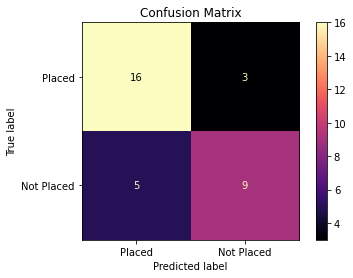

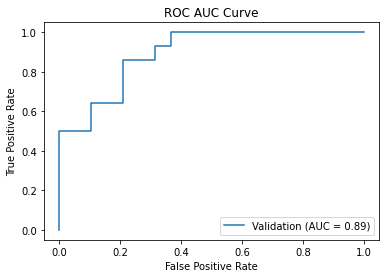

In [10]:
classifier = LogisticRegression
param = {"C":1, "random_state":20}
model_name = 'Lt'
run_name = 'LogisticRegression_model'
model_experimentation(classifier, param, model_name, run_name)

## Decision Tree Training and evaluation + MLFlow for model tracking

Validation AUC:0.8571428571428572


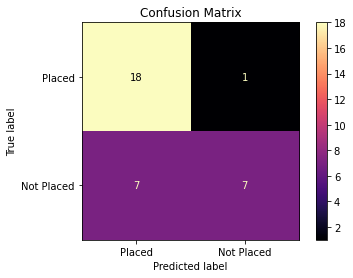

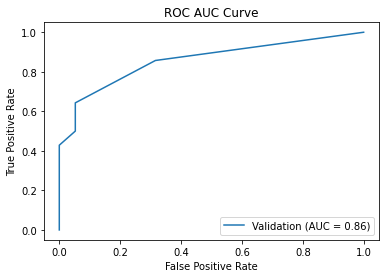

In [11]:
classifier = DecisionTreeClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'dt'
run_name = 'DecisionTree_model'
model_experimentation(classifier, param, model_name, run_name)

## Random Forest Training and evaluation + MLFlow for model tracking

Validation AUC:0.887218045112782


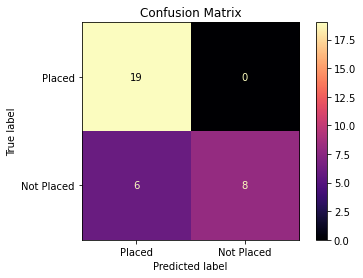

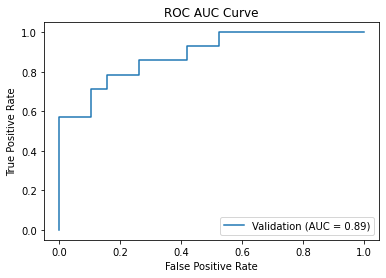

In [12]:
classifier = RandomForestClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'rf'
run_name = 'randomForest_model'
model_experimentation(classifier, param, model_name, run_name)

## Gradient Boosting Training and evaluation + MLFlow for model tracking

Validation AUC:0.8909774436090225


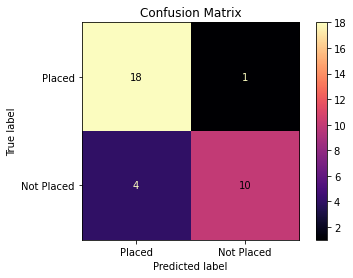

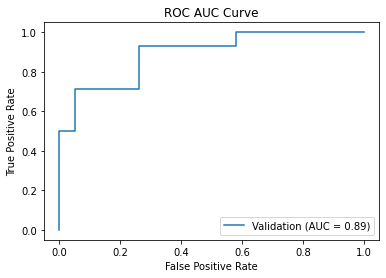

In [13]:
classifier = GradientBoostingClassifier
param = {"max_depth":3, "random_state":20}
model_name = 'gbm'
run_name = 'GradientBoosting_model'
model_experimentation(classifier, param, model_name, run_name)

## Lightgbm Training and evaluation + MLFlow for model tracking

Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.980254	valid_1's auc: 0.883459
[40]	training's auc: 0.989177	valid_1's auc: 0.906015
[60]	training's auc: 0.994442	valid_1's auc: 0.902256
[80]	training's auc: 0.998245	valid_1's auc: 0.917293
[100]	training's auc: 0.999561	valid_1's auc: 0.917293
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.999561	valid_1's auc: 0.917293
Validation AUC:0.9172932330827068


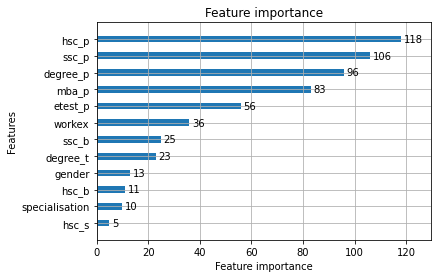

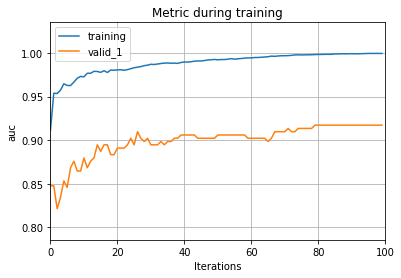

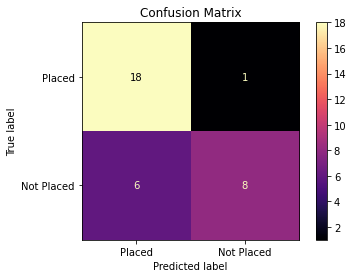

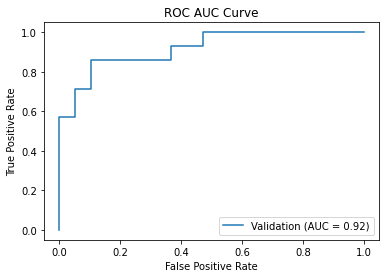

In [14]:
# Launching Multiple Runs in One Program.This is easy to do because the ActiveRun object returned by mlflow.start_run() is a 
# Python context manager. You can “scope” each run to just one block of code as follows:
with mlflow.start_run(experiment_id=experiment_id, run_name='Lightgbm_model') as run:
    # Get run id 
    run_id = run.info.run_uuid

    # Provide brief notes about the run
    MlflowClient().set_tag(run_id,
                           "mlflow.note.content",
                           "This is experiment for exploring different machine learning models for Campus Recruitment Dataset")

        
    # Define tag
    tags = {"Application": "Payment Monitoring Platform",
            "release.candidate": "PMP",
            "release.version": "2.2.0"}
            
    # Set Tag
    mlflow.set_tags(tags)
    
    # Log python environment details
    mlflow.log_artifact('requirements.txt')

    # Define model parameter
    params = {
        "objective": "binary",
        "learning_rate": 0.05,
        "metric": "auc",
        "colsample_bytree": 0.7,
        "subsample": 0.8,
        "seed": 42,
    }
        
    # logging params
    mlflow.log_params(params)
    
    # Perform model training
    lgb_clf = LGBMClassifier(**params)
    lgb_clf.fit(X_train, y_train, 
                eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                early_stopping_rounds=50,
                verbose=20)
        
    # Log model artifacts
    mlflow.sklearn.log_model(lgb_clf, "model")
    
    # Perform model evaluation 
    lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
    roc_auc = auc(fpr, tpr) # compute area under the curve
    print("=====================================")
    print("Validation AUC:{}".format(roc_auc))
    print("=====================================")   
        
    # log metrics
    mlflow.log_metrics({"Validation_AUC": roc_auc})
       
    # Plot and save feature importance details
    ax = plot_importance(lgb_clf, height=0.4)
    filename = './images/lgb_validation_feature_importance.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    ax = plot_metric(lgb_clf.evals_result_)
    filename = './images/lgb_validation_metrics_comparision.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    # Plot and save metrics details    
    plot_confusion_matrix(lgb_clf, X_valid, y_valid, 
                          display_labels=['Placed', 'Not Placed'],
                          cmap='magma')
    plt.title('Confusion Matrix')
    filename = './images/lgb_validation_confusion_matrix.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)
    
    # Plot and save AUC details  
    plot_roc_curve(lgb_clf, X_valid, y_valid, name='Validation')
    plt.title('ROC AUC Curve')
    filename = './images/lgb_validation_roc_curve.png'
    plt.savefig(filename)
    # log model artifacts
    mlflow.log_artifact(filename)

## Reference

### Model experimentation
https://www.mlflow.org/docs/latest/tracking.html#

### Hyperparameter Optimization
https://github.com/optuna/optuna